In [4]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

norm_bible=["While the Word2Vec family of models are unsupervised, what this means is that you can just give it a corpus without additional labels or information and it can construct dense word embeddings from the corpus.",
            "But you will still need to leverage a supervised, classification methodology once you have this corpus to get to these embeddings.",
            "But we will do that from within the corpus itself, without any auxiliary information.",
            " We can model this CBOW architecture now as a deep learning classification model such that we take in the context words as our input, X and try to predict the target word, Y. In fact building this architecture is simpler than the skip-gram model where we try to predict a whole bunch of context words from a source target word."
           ]
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

('Vocabulary Size:', 80)
('Vocabulary Sample:', [('and', 18), ('our', 66), ('learning', 63), ('classification', 22), ('give', 40), ('predict', 29), ('skip', 74), ('is', 14), ('labels', 42), ('it', 15)])


In [8]:
import numpy as np
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

('Context (X):', ['while', 'the', 'family', 'of'], '-> Target (Y):', 'word2vec')
('Context (X):', ['the', 'word2vec', 'of', 'models'], '-> Target (Y):', 'family')
('Context (X):', ['word2vec', 'family', 'models', 'are'], '-> Target (Y):', 'of')
('Context (X):', ['family', 'of', 'are', 'unsupervised'], '-> Target (Y):', 'models')
('Context (X):', ['of', 'models', 'unsupervised', 'what'], '-> Target (Y):', 'are')
('Context (X):', ['models', 'are', 'what', 'this'], '-> Target (Y):', 'unsupervised')
('Context (X):', ['are', 'unsupervised', 'this', 'means'], '-> Target (Y):', 'what')
('Context (X):', ['unsupervised', 'what', 'means', 'is'], '-> Target (Y):', 'this')
('Context (X):', ['what', 'this', 'is', 'that'], '-> Target (Y):', 'means')
('Context (X):', ['this', 'means', 'that', 'you'], '-> Target (Y):', 'is')
('Context (X):', ['means', 'is', 'you', 'can'], '-> Target (Y):', 'that')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            8000      
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
Total params: 16,080
Trainable params: 16,080
Non-trainable params: 0
_________________________________________________________________
None


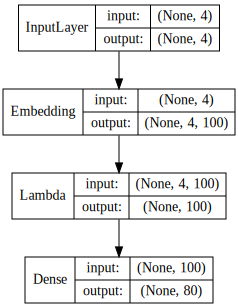

In [9]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [14]:
loss_acc = []
for epoch in range(1, 1000):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    if epoch % 100 == 0:
        print('Epoch:', epoch, ' Loss:', loss)
    loss_acc.append(loss)

('Epoch:', 100, ' Loss:', 0.070042146927335125)
('Epoch:', 200, ' Loss:', 6.0379752838457534e-05)
('Epoch:', 300, ' Loss:', 1.5616416931152344e-05)
('Epoch:', 400, ' Loss:', 1.5616416931152344e-05)
('Epoch:', 500, ' Loss:', 1.5616416931152344e-05)
('Epoch:', 600, ' Loss:', 1.5616416931152344e-05)
('Epoch:', 700, ' Loss:', 1.5616416931152344e-05)
('Epoch:', 800, ' Loss:', 1.5616416931152344e-05)
('Epoch:', 900, ' Loss:', 1.5616416931152344e-05)


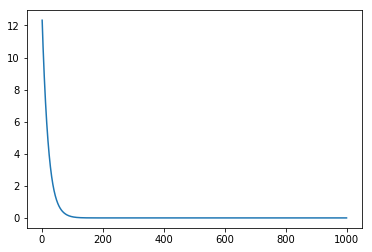

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

x = xrange(1,len(loss_acc)+1)
plt.plot(x, loss_acc)
plt.show()

In [23]:
import pandas as pd

weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(79, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,1.266133,0.349702,0.267971,-0.561434,1.188601,0.978859,1.273472,-1.679764,2.117352,0.012177,...,0.967358,1.825161,-1.785416,0.503959,-3.532048,0.685769,1.186739,0.131504,-0.307449,-0.213507
a,0.764007,0.092310,-1.018833,-0.124648,0.154430,0.509249,-0.483014,-0.223415,3.750870,1.165278,...,-1.461299,1.628567,0.622636,-1.497438,0.779358,0.462160,4.330284,-0.186747,0.998975,0.209154
to,-1.361582,0.193226,1.877105,1.114656,-1.716753,-0.358301,2.157027,1.909365,-1.167614,0.028600,...,0.466472,-0.737329,-1.399071,0.498821,0.667459,0.996844,1.196580,0.299213,-2.160282,0.246660
this,-0.667266,-1.686569,0.180730,-0.596966,0.708851,1.805048,0.457329,-0.318155,2.964148,-0.890817,...,0.584667,-1.775401,-0.587846,-0.298438,-1.923433,2.214738,0.156102,-0.285599,0.725975,1.995872
corpus,-2.604547,0.773301,1.616210,-0.751094,1.349274,-1.279612,-0.695607,0.071027,-0.122662,0.133631,...,-0.615990,0.292098,0.513560,-0.196050,0.132287,-1.946740,0.894451,-2.315251,-1.206102,-0.355389


In [24]:
# Test similar words
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['word2vec', 'unsupervised']}

similar_words

(79, 79)


{'unsupervised': ['what', 'are', 'give', 'learning', 'means'],
 'word2vec': ['models', 'bunch', 'fact', 'do', 'our']}

# JUST ANOTHER CBOW IMPLEMENTATION

In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
import tensorflow as tf

Using TensorFlow backend.


In [3]:
def tokenize(corpus):
    """Tokenize the corpus text.
    :param corpus: list containing a string of text (example: ["I like playing football with my friends"])
    :return corpus_tokenized: indexed list of words in the corpus, in the same order as the original corpus (the example above would return [[1, 2, 3, 4]])
    :return V: size of vocabulary
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    V = len(tokenizer.word_index)
    return corpus_tokenized, V

In [4]:
def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def corpus2io(corpus_tokenized, V, window_size):
    """Converts corpus text into context and center words
    # Arguments
        corpus_tokenized: corpus text
        window_size: size of context window
    # Returns
        context and center words (arrays)
    """
    for words in corpus_tokenized:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels = []
            s = index - window_size
            e = index + window_size + 1
            contexts.append([words[i]-1 for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word-1)
            x = np_utils.to_categorical(contexts, V)
            y = np_utils.to_categorical(labels, V)
            yield (x, y.ravel())

In [7]:
window_size = 2
corpus = ["I like playing football with my friends"]
corpus_tokenized, V = tokenize(corpus)
for i, (x, y) in enumerate(corpus2io(corpus_tokenized, V, window_size)):
    print(i)
    print("center word =", y)
    print("context words =")
    print(x)

0
('center word =', array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]))
context words =
[[ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]]
1
('center word =', array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]))
context words =
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
2
('center word =', array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.]))
context words =
[[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]]
3
('center word =', array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]))
context words =
[[ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]]
4
('center word =', array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]))
context words =
[[ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
5
('center word =', array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]))
cont

In [8]:
def softmax(x):
    """Calculate softmax based probability for given input vector
    # Arguments
        x: numpy array/list
    # Returns
        softmax of input array
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [19]:
def cbow(context, label, W1, W2, loss):
    """
    Implementation of Continuous-Bag-of-Words Word2Vec model
    :param context: all the context words (these represent the inputs)
    :param label: the center word (this represents the label)
    :param W1: weights from the input to the hidden layer
    :param W2: weights from the hidden to the output layer
    :param loss: float that represents the current value of the loss function
    :return: updated weights and loss
    """
    x = np.mean(context, axis=0)
    print(W1.shape, x.shape)
    h = np.dot(W1.T, x)
    print(h)
    u = np.dot(W2.T, h)
    y_pred = softmax(u)

    e = -label + y_pred
    dW2 = np.outer(h, e)
    dW1 = np.outer(x, np.dot(W2, e))

    new_W1 = W1 - eta * dW1
    new_W2 = W2 - eta * dW2

    loss += -float(u[label == 1]) + np.log(np.sum(np.exp(u)))

    return new_W1, new_W2, loss

In [20]:
#user-defined parameters
corpus = ["I like playing football with my friends"] #our example text corpus
N = 2 #assume that the hidden layer has dimensionality = 2
window_size = 2 #symmetrical
eta = 0.1 #learning rate

corpus_tokenized, V = tokenize(corpus)

#initialize weights (with random values) and loss function
np.random.seed(100)
W1 = np.random.rand(V, N)
W2 = np.random.rand(N, V)
loss = 0.

for i, (context, label) in enumerate(corpus2io(corpus_tokenized, V, window_size)):
    W1, W2, loss = cbow(context, label, W1, W2, loss)
    print("Training example #{} \n-------------------- \n\n \t label = {}, \n \t context = {}".format(i, label, context))
    print("\t W1 = {}\n\t W2 = {} \n\t loss = {}\n".format(W1, W2, loss))

((7, 2), (7,))
[ 0.21461822  0.48317263]
Training example #0 
-------------------- 

 	 label = [ 1.  0.  0.  0.  0.  0.  0.], 
 	 context = [[ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]]
	 W1 = [[ 0.54340494  0.27836939]
 [ 0.40739238  0.86832668]
 [-0.01240636  0.14511967]
 [ 0.67074908  0.82585276]
 [ 0.13670659  0.57509333]
 [ 0.89132195  0.20920212]
 [ 0.18532822  0.10837689]]
	 W2 = [[  2.37522044e-01   9.74588882e-01   8.08598345e-01   1.69452859e-01
    8.13081663e-01   2.71730692e-01   4.28973634e-01]
 [  9.80158449e-01   8.08565553e-01   3.29167094e-01   1.69808842e-01
    3.65755980e-01   4.13558689e-04   2.46279033e-01]] 
	 loss = 1.77504194359

((7, 2), (7,))
[ 0.40058256  0.41644727]
Training example #1 
-------------------- 

 	 label = [ 0.  1.  0.  0.  0.  0.  0.], 
 	 context = [[ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
	 W1 = [[  5.56639604e-01   2.89686158e-01]
 [  4.07392378e-01   8.68326677e-01]
 [

In [12]:
h

NameError: name 'h' is not defined